In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib as mpl
from datetime import datetime
import plotly.express as px
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.callbacks import EarlyStopping

mpl.rcParams['figure.figsize'] = (20, 15)
mpl.rcParams['axes.grid'] = False

import tensorflow as tf 
np.random.seed(42)
tf.random.set_seed(42)


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [2]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
ls'/content/gdrive/My Drive/Thesis'

dataframe_dma_flow_1D.csv     dataframe_flow_variable_1D.csv     DMA_468.csv
dataframe_dma_flow_60min.csv  dataframe_flow_variable_60min.csv
dataframe_flow_1D.csv         DMA_225.csv


In [4]:
data = pd.read_csv("/content/gdrive/My Drive/Thesis/dataframe_flow_variable_60min.csv")
data['Unnamed: 0'] = pd.to_datetime(data['Unnamed: 0'])
data.rename( columns={'Unnamed: 0':'Date_time','225':'DMA_225'}, inplace=True )

In [5]:
data_DMA225 = data[['Date_time','DMA_225','tempC','HeatIndexC','FeelsLikeC','WindChillC','windspeedKmph','sunHour','precipMM','humidity']]

In [6]:
data_DMA225.shape

(2208, 10)

In [7]:
data_DMA225_indexed = data_DMA225.set_index('Date_time')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb3b3adb810>,
      dtype=object)

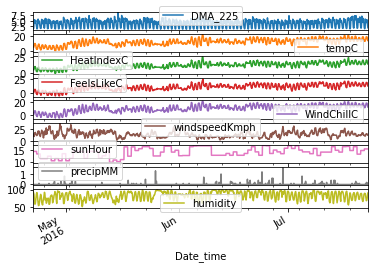

In [8]:
data_DMA225_indexed[['DMA_225','tempC','HeatIndexC','FeelsLikeC','WindChillC','windspeedKmph','sunHour','precipMM','humidity']].plot(subplots=True)

In [9]:
data_DMA225_indexed.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2208 entries, 2016-04-22 00:00:00 to 2016-07-22 23:00:00
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DMA_225        2208 non-null   float64
 1   tempC          2208 non-null   int64  
 2   HeatIndexC     2208 non-null   int64  
 3   FeelsLikeC     2208 non-null   int64  
 4   WindChillC     2208 non-null   int64  
 5   windspeedKmph  2208 non-null   int64  
 6   sunHour        2208 non-null   float64
 7   precipMM       2208 non-null   float64
 8   humidity       2208 non-null   int64  
dtypes: float64(3), int64(6)
memory usage: 172.5 KB


In [10]:
# Making hourly data 
hourly_data = data_DMA225_indexed.resample('h').sum()

hourly_data.isnull().sum().sum()
hourly_data.isna().sum().sum()
data_hourly = hourly_data.values
#Scaling the data 
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_hourly)
scaled_hourlydata = pd.DataFrame(scaled_data)
# scaled_data = scaler.fit_transform(hourly_data)
# scaled_hourlydata = pd.DataFrame(scaled_data)

# Restructuring the data
def reshaped_hourlydata(data,step_input,step_output):
  final_data =  np.array([data[i:i + (step_input+step_output)].copy() for i in range(len(data) - (step_input+step_output))])
  return final_data

final_hourlydata = reshaped_hourlydata(scaled_hourlydata,12,24)
# #final_hourlydata = reshaped_hourlydata(data_hourly,12,24)
final_hourlydata.shape

(2172, 36, 9)

In [11]:
train_size = int(len(final_hourlydata)*0.6)
remaining_data = len(final_hourlydata) - train_size
# With the remaining data 70% is considered for validation set and 30% for test set.
validation_data = int((remaining_data)*0.7)
testing_data = remaining_data-validation_data
valid_size = (train_size)+(validation_data)
#valid_size = int(len(final_hourlydata)*0.9)
#train_size = 5234
# valid_size = 7415
# Restructing the dataset:
step_input = 12
step_output = 24

train_X = final_hourlydata[:train_size, :step_input]
valid_X = final_hourlydata[train_size:valid_size, :step_input]
test_X = final_hourlydata[valid_size:, :step_input]
y = np.empty((len(final_hourlydata), step_input, step_output))
for future_value in range(1, step_output + 1):
    y[..., future_value - 1] = final_hourlydata[..., future_value:future_value + step_input, 0]
train_y = y[:train_size]
valid_y = y[train_size:valid_size]
test_y = y[valid_size:]

print("The shape of train_X is:",train_X.shape)
print("The shape of valid_X is:",valid_X.shape)
print("The shape of test_X is:",test_X.shape)

print("The shape of train_y is:",train_y.shape)
print("The shape of valid_y is:",valid_y.shape)
print("The shape of test_y is:",test_y.shape)

The shape of train_X is: (1303, 12, 9)
The shape of valid_X is: (608, 12, 9)
The shape of test_X is: (261, 12, 9)
The shape of train_y is: (1303, 12, 24)
The shape of valid_y is: (608, 12, 24)
The shape of test_y is: (261, 12, 24)


In [12]:
# model = keras.models.Sequential([
# keras.layers.LSTM(150,return_sequences=True, input_shape=(12,9)),
# keras.layers.Dropout(0.1),
# keras.layers.Dense(170,kernel_initializer='normal'),
# #keras.layers.Dropout(0.35),
# keras.layers.Dense(120,kernel_initializer='normal'),
# #keras.layers.Dropout(0.45),
# keras.layers.Dense(24)
# ])

model = keras.models.Sequential([
keras.layers.LSTM(100,return_sequences=True, input_shape=(12,9)),
keras.layers.Dropout(0.1),
keras.layers.Dense(70,kernel_initializer='normal'),
#keras.layers.Dropout(0.35),
keras.layers.Dense(70,kernel_initializer='normal'),
#keras.layers.Dropout(0.45),
keras.layers.Dense(24)
])
#opt = keras.optimizers.Adam(learning_rate=0.009)
#model.compile(loss='mse', optimizer=opt),
model.compile(loss='mae', optimizer='adam'),
history = model.fit(train_X,train_y, batch_size = 100,epochs = 80,validation_data=(valid_X, valid_y))

Epoch 1/80
14/14 [==============================] - 4s 113ms/step - loss: 0.2978 - val_loss: 0.2011
Epoch 2/80
14/14 [==============================] - 0s 36ms/step - loss: 0.1969 - val_loss: 0.1671
Epoch 3/80
14/14 [==============================] - 1s 41ms/step - loss: 0.1781 - val_loss: 0.1516
Epoch 4/80
14/14 [==============================] - 1s 38ms/step - loss: 0.1640 - val_loss: 0.1472
Epoch 5/80
14/14 [==============================] - 0s 36ms/step - loss: 0.1547 - val_loss: 0.1316
Epoch 6/80
14/14 [==============================] - 0s 36ms/step - loss: 0.1433 - val_loss: 0.1242
Epoch 7/80
14/14 [==============================] - 1s 42ms/step - loss: 0.1346 - val_loss: 0.1199
Epoch 8/80
14/14 [==============================] - 1s 40ms/step - loss: 0.1280 - val_loss: 0.1159
Epoch 9/80
14/14 [==============================] - 0s 36ms/step - loss: 0.1253 - val_loss: 0.1136
Epoch 10/80
14/14 [==============================] - 0s 34ms/step - loss: 0.1220 - val_loss: 0.1147
Epoch 11

In [13]:
# Plot train loss and validation loss
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')

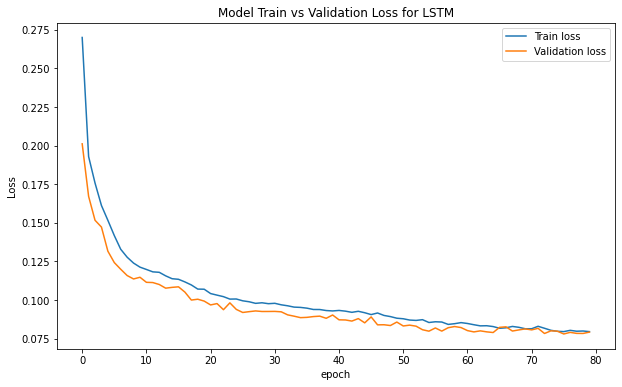

In [14]:

plot_loss(history,'LSTM')

In [15]:
#Generate predictions
train_pred = model.predict(train_X)
#evaluation = model.evaluate(x=X_test, y=y_test, verbose=1)
test_pred = model.predict(test_X)
predictions = test_pred

In [16]:
# To make a dataframe of original and predicted value:
lstm_df=[]
for i in range (0, len(predictions)):
  lstm_df.append((predictions[i][0][step_output-1]))
final_df = pd.DataFrame((test_X[:,0]))
final_df.rename(columns = {0:'original_value'}, inplace = True)
final_df['predicted_value'] = lstm_df

In [17]:
# To calculate the percentage difference between actual and predicted value:
final_df['total_difference'] = (final_df['predicted_value'] - final_df['original_value']).abs()
final_df['percentage_difference'] = ((final_df['total_difference'])/(final_df['original_value']))*100

In [18]:
import math
from sklearn.metrics import mean_squared_error
#testset = math.sqrt(mean_squared_error(final_df['original_value'], final_df['predicted_value']))
testset = math.sqrt(mean_squared_error(final_df['original_value'], final_df['predicted_value']))
print("The RMSE prediction value on testset: ",testset)

The RMSE prediction value on testset:  0.022413925553471954


In [19]:
# To make complete df:
y = [y[0] for y in test_y]
df_r = hourly_data.reset_index()
days = df_r['Date_time'].values[-len(y):]
df = pd.DataFrame(days,columns = ['Date_time'])
result = pd.concat([df, final_df], axis=1, join='inner')
result.shape

(261, 13)

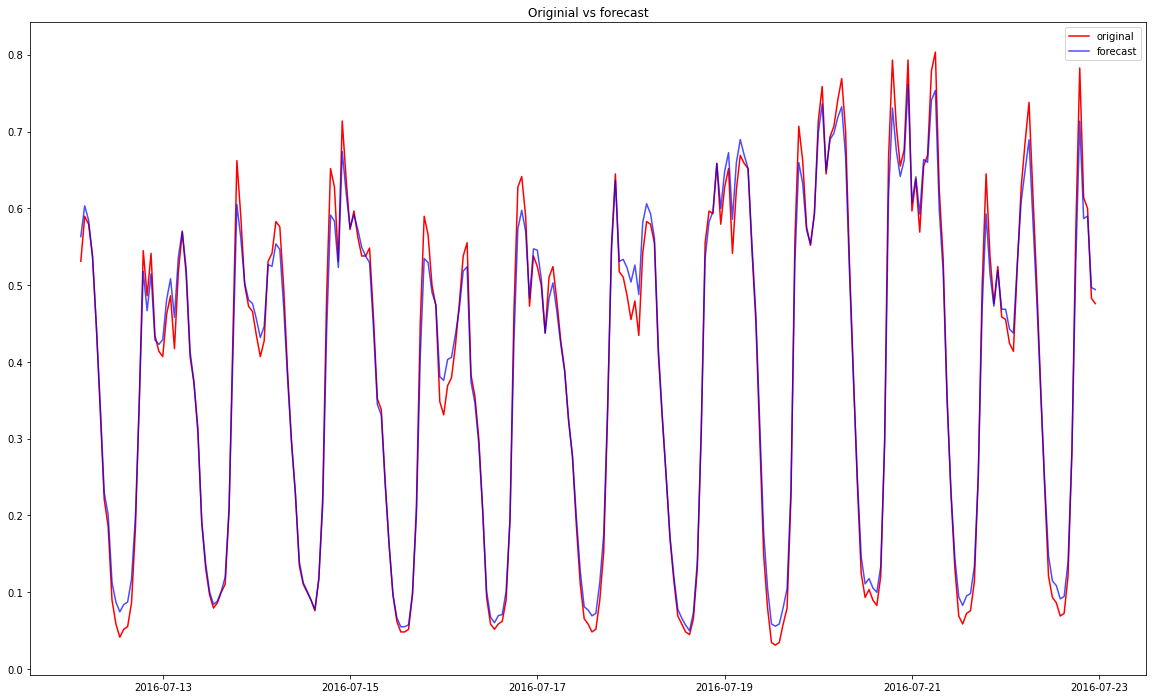

In [20]:
# Plotting original and predicted graph:
plt.figure(figsize=(20, 12))
plt.plot(result.Date_time, result.original_value, color='red', label='original')
plt.plot(result.Date_time, result.predicted_value, color='blue', label='forecast', alpha=0.7)
plt.title('Originial vs forecast')
plt.legend()
plt.show()

In [26]:
from google.colab import files

# e.g. save pandas output as csv
result.to_csv('DMA_225_MLSTM.csv')

# or any other file as usual
# with open('example.csv', 'w') as f:
#   f.write('your strings here')

files.download('DMA_225_MLSTM.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# New Section